## **Overview**

In this notebook, load and save operations of data files supported by PySpark are performed.

There are many other data sources available in PySpark such as csv, json, parquet, JDBC, text, binaryFile, Avro, etc. See also the latest [Spark SQL, DataFrames and Datasets Guide](https://spark.apache.org/docs/latest/sql-programming-guide.html) in Apache Spark documentation.

1- read in data from variou format

2- data exploration and pivot table

3- data visualization using seaborn

4- sql queries

[source](https://spark.apache.org/docs/latest/sql-getting-started.html)

### **Install PySpark**

In [ ]:
# install PySpark
# ! pip install pyspark==3.2.0

### **Initializing Spark**

In [83]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

spark

In [2]:
# import libraries
import pandas as pd

### **Read in files**
### 1. CSV files

1.1 -**spark.read().csv("file_name")** to read a file or directory of files in CSV format into Spark DataFrame, and **dataframe.write().csv("path")** to write to a CSV file. Function **option()** can be used to customize the behavior of reading or writing, such as controlling behavior of the header, delimiter character, character set, and so on.

1.2 - **.format().options().load()**

In [ ]:
# 1.1 spark.read().csv("file_name")
# read in a single csv file
csv_path = "../health_etl/data/BenefitsCostSharing.csv"

benefits = spark.read.csv(csv_path,header=True)  
benefits.show(10)

# can also change deliminaters according to files
# for example, spark.read.options(delimiter="\t",header=True).csv(csv_path)

# 1.2  .format().options().load()
benefits = spark.read.format("csv").options(delimiter=",", header=True).load("../health_etl/data/BenefitsCostSharing.csv")

### 2. **TSV (Tab-separated Values ) files**

tsv_path = "/content/taxis.tsv"

data_taxiss = spark.read.options(delimiter="\t",header=True).csv(tsv_path)


In [ ]:
# Write and Read Text files

# df.write().text("file_name.txt")
# df = spark.read().text("file_name.txt")

### 3 **JSON files**
Spark SQL can automatically infer the schema of a JSON dataset and load it as a DataFrame. This conversion can be done using SparkSession.read.json on a JSON file.

Note that the file that is offered as a json file is not a typical JSON file. Each line must contain a separate, self-contained valid JSON object.

In [ ]:
# Write and Read json file

# df.write.json('file_name.json')
# df = spark.read.json('file_name.json')

### 4. **Parquet Files**
Parquet is a columnar format that is supported by many other data processing systems. Spark SQL provides support for both reading and writing Parquet files that automatically preserves the schema of the original data. When reading Parquet files, all columns are automatically converted to be nullable for compatibility reasons.

In [ ]:
# Write and Read PARQUET

# df.write.parquet('file_name.parquet')
# df = spark.read.parquet('file_name.parquet')

parquetFile = spark.read.option("delimiter", ";")\
                        .option("header", True)\
                        .parquet("amazonFood.parquet")

### **Data exploration**

Use the claim data to do a demo on data visualization

In [ ]:
# ! pip install seaborn

In [ ]:
from datetime import datetime, date
from pyspark.sql import Row
import pandas as pd 
import seaborn as sns
from pyspark.sql.functions import *

In [ ]:
# import data
csv_path = "../health_etl/data/BenefitsCostSharing.csv"
benefits = spark.read.csv(csv_path,header=True)  
benefits.show()
benefits.count()    # count rows
benefits.select("BenefitName").distinct().count()  # count unique value in a column

In [ ]:
### Check the schema
benefits.printSchema()

### column manipulation

- change column name, `withColumnRenamed("_c0","id")`;

- check all columns, 
- drop some coclumns, `drop("col1","col2","col3")`

In [ ]:
# 1. change column name
# benefits = benefits.withColumnRenamed("old_name","new_name")

# 2. check all column and drop same columns 
# benefits.select("survived","alive","embarked","embark_town","pclass","class").show(10)
benefits = benefits.drop("StandardComponentId","StateCode2","IssuerId2","CoinsInnTier2")

### Missing value

- check missing value
- fill in missing value with imputed value (numeric)
- replace categorical with numberical value

In [ ]:
# check missing value

for i in benefits.columns:
  print(i,benefits.count()-(benefits.na.drop(subset=i).count()))


In [ ]:
## drop na in a column >> this will result a smaller rows
benefits =benefits.na.drop(subset=["BusinessYear"])

In [ ]:
# Fill in missing value
# pyspark.imputer
# Imputation estimator for completing missing values, using the mean, median or mode of the columns in which the missing values are located.
# The input columns should be of numeric type. Currently Imputer does not support categorical features and possibly creates incorrect values for a categorical feature.

# fill null values in age colum with median 
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['age'], 
    outputCols=["{}_imputed".format(c) for c in ['age']]
    ).setStrategy("median")

In [ ]:
# replace categoric values with 0 and 1

from pyspark.sql.functions import col , udf

Dict = {'Yes':'1','No':'0'}   # this dictionary can also be used for other columns transfer
map_func = udf(lambda row : Dict.get(row,row))

benefits = benefits.withColumn("QuantLimitOnSvc", map_func(col("QuantLimitOnSvc")))

benefits.show(10)

## pivot table and ploting

In [3]:
## import data 
csv_path = "../health_etl/data/ServiceArea.csv"
service = spark.read.csv(csv_path,header=True)  

import matplotlib.pyplot as plt

In [4]:
service.show()

+------------+---------+--------+----------+----------+-------------------+---------+----------+-------------+--------------------+----------------+-------+-------------+--------+--------------------------+---------+--------------+--------------+
|BusinessYear|StateCode|IssuerId|SourceName|VersionNum|         ImportDate|IssuerId2|StateCode2|ServiceAreaId|     ServiceAreaName|CoverEntireState| County|PartialCounty|ZipCodes|PartialCountyJustification|RowNumber|MarketCoverage|DentalOnlyPlan|
+------------+---------+--------+----------+----------+-------------------+---------+----------+-------------+--------------------+----------------+-------+-------------+--------+--------------------------+---------+--------------+--------------+
|        2014|       PA|   22444|      HIOS|         9|2014-01-21 08:29:49|    22444|        PA|       PAS001|Geisinger Health ...|              No|42103.0|           No|    null|                      null|       42|          null|          null|
|        201

In [5]:
service.select("SourceName").distinct().count()

3

In [6]:
service.select("StateCode").distinct().count()

39

In [7]:
# pivot table
service.groupBy('StateCode').pivot("SourceName").count().show()

+---------+----+----+-----+
|StateCode|HIOS| OPM|SERFF|
+---------+----+----+-----+
|       SC| 240|   4| null|
|       AZ| 232|null| null|
|       LA| 491|   3| null|
|       NJ| 343|null| null|
|       OR|null|   2|  625|
|       VA|   1| 432| 4242|
|       WY|  46|null| null|
|       NH|null|   3|  196|
|       MI|   1| 139| 6077|
|       NV|null|   8|  126|
|       WI|1315| 102| null|
|       ID|null|null|  188|
|       NE|null|null| 1185|
|       MT|null|   3|  128|
|       NC|1086|  85| null|
|       DE|null|   3|   53|
|       MO|2022| 255| null|
|       IL|   1| 108| 2107|
|       ME|null|  48|  157|
|       ND| 251|null| null|
+---------+----+----+-----+
only showing top 20 rows



## **Data visualization**

Text(0, 0.5, 'number of services')

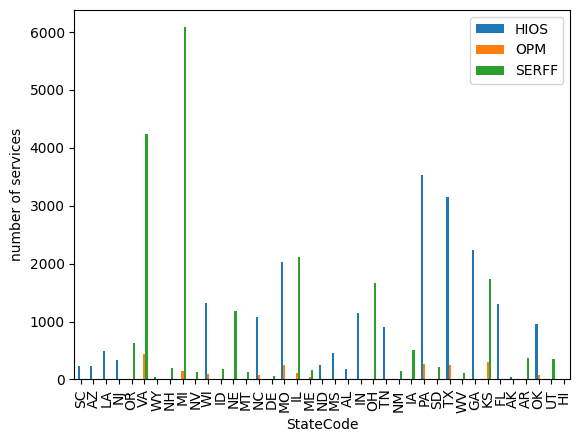

In [17]:
# plot for pivot table 
df = service.groupBy('StateCode').pivot("SourceName").count().toPandas()
df = df.set_index('StateCode')

ax = df.plot(kind="bar")
ax.set_xlabel("StateCode")
ax.set_ylabel("number of services")

Text(0.5, 24.0, 'StateCode')

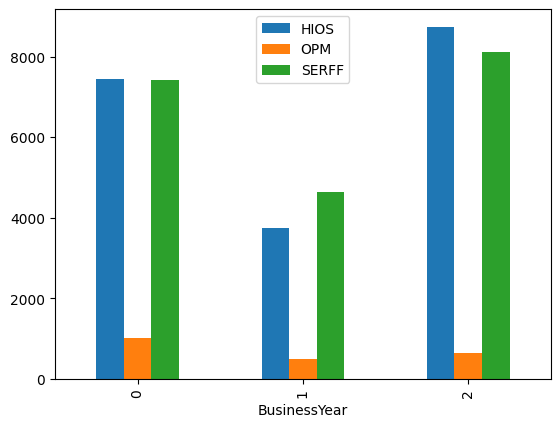

In [19]:
service.groupBy('BusinessYear').pivot("SourceName").count().toPandas().plot(kind="bar")
plt.xlabel("BusinessYear")

## interactive plot

In [ ]:
# ! pip install plotly
# ! pip install nbformat==5.0.2

# https://plotly.com/python/bar-charts/

In [24]:
import plotly.express as px

df = service.groupBy('BusinessYear').pivot("SourceName").count().toPandas()

df = df = df.sort_values(by=['BusinessYear'], ascending=True) 
fig = px.bar(df, x='BusinessYear', y=['HIOS', 'OPM','SERFF'], 
             title='Proportion of different cover source by buisiness year')
fig.show()


In [25]:
import plotly.express as px

df = service.groupBy('StateCode').pivot("SourceName").count().toPandas()

df = df.sort_values(by=['HIOS'], ascending=False)  ## here manipulate on how the order is showing on create df
fig = px.bar(df, x='StateCode', y=['HIOS', 'OPM','SERFF'], 
             title='Sum of different cover source by StateCode')
fig.show()

## correlation

In [70]:
## import data 
csv_path = "../health_etl/data/BusinessRules.csv"
rules = spark.read.csv(csv_path,header=True)  

In [71]:
rules.show(10)

+------------+---------+--------+----------+----------+-------------------+---------+----------+---------+-------------------+-------------------------------------+--------------------------------+-----------------------------------+----------------------+-----------------------------------+--------------------------------+-------------------------------+--------------------+----------------------------+--------------------+---------+--------------+--------------+
|BusinessYear|StateCode|IssuerId|SourceName|VersionNum|         ImportDate|IssuerId2|       TIN|ProductId|StandardComponentId|EnrolleeContractRateDeterminationRule|TwoParentFamilyMaxDependentsRule|SingleParentFamilyMaxDependentsRule|DependentMaximumAgRule|ChildrenOnlyContractMaxChildrenRule|DomesticPartnerAsSpouseIndicator|SameSexPartnerAsSpouseIndicator|AgeDeterminationRule|MinimumTobaccoFreeMonthsRule|    CohabitationRule|RowNumber|MarketCoverage|DentalOnlyPlan|
+------------+---------+--------+----------+----------+-------

In [72]:
# replace categoric values with 0 and 1

from pyspark.sql.functions import col , udf

## change two columns
Dict = {'Yes':'1','No':'0'}   # this dictionary can also be used for other columns transfer
map_func = udf(lambda row : Dict.get(row,row))

rules = rules.withColumn("DomesticPartnerAsSpouseIndicator", map_func(col("DomesticPartnerAsSpouseIndicator")))
rules = rules.withColumn("SameSexPartnerAsSpouseIndicator", map_func(col("SameSexPartnerAsSpouseIndicator")))

## change 3 columns with same dictionary
Dict = {'1':1,'null':0,'3 or more':3, '2':2}   # this dictionary can also be used for other columns transfer
map_func = udf(lambda row : Dict.get(row,row))
cols_to_modify = ['TwoParentFamilyMaxDependentsRule', 'SingleParentFamilyMaxDependentsRule','ChildrenOnlyContractMaxChildrenRule']

for col_name in cols_to_modify:
    rules = rules.withColumn(col_name, map_func(col(col_name)))

In [73]:
rules.printSchema()

root
 |-- BusinessYear: string (nullable = true)
 |-- StateCode: string (nullable = true)
 |-- IssuerId: string (nullable = true)
 |-- SourceName: string (nullable = true)
 |-- VersionNum: string (nullable = true)
 |-- ImportDate: string (nullable = true)
 |-- IssuerId2: string (nullable = true)
 |-- TIN: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- StandardComponentId: string (nullable = true)
 |-- EnrolleeContractRateDeterminationRule: string (nullable = true)
 |-- TwoParentFamilyMaxDependentsRule: string (nullable = true)
 |-- SingleParentFamilyMaxDependentsRule: string (nullable = true)
 |-- DependentMaximumAgRule: string (nullable = true)
 |-- ChildrenOnlyContractMaxChildrenRule: string (nullable = true)
 |-- DomesticPartnerAsSpouseIndicator: string (nullable = true)
 |-- SameSexPartnerAsSpouseIndicator: string (nullable = true)
 |-- AgeDeterminationRule: string (nullable = true)
 |-- MinimumTobaccoFreeMonthsRule: string (nullable = true)
 |-- Cohabitatio

In [74]:
## change multiple string column into int type
# create a list of columns to cast
cols_to_cast = ['IssuerId','TwoParentFamilyMaxDependentsRule', 'SingleParentFamilyMaxDependentsRule',
                'ChildrenOnlyContractMaxChildrenRule','DomesticPartnerAsSpouseIndicator','SameSexPartnerAsSpouseIndicator']

# cast the selected columns to integer using a list comprehension
rules = rules.select([col(c).cast('int').alias(c) if c in cols_to_cast else c for c in rules.columns])

rules.printSchema()


root
 |-- BusinessYear: string (nullable = true)
 |-- StateCode: string (nullable = true)
 |-- IssuerId: integer (nullable = true)
 |-- SourceName: string (nullable = true)
 |-- VersionNum: string (nullable = true)
 |-- ImportDate: string (nullable = true)
 |-- IssuerId2: string (nullable = true)
 |-- TIN: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- StandardComponentId: string (nullable = true)
 |-- EnrolleeContractRateDeterminationRule: string (nullable = true)
 |-- TwoParentFamilyMaxDependentsRule: integer (nullable = true)
 |-- SingleParentFamilyMaxDependentsRule: integer (nullable = true)
 |-- DependentMaximumAgRule: string (nullable = true)
 |-- ChildrenOnlyContractMaxChildrenRule: integer (nullable = true)
 |-- DomesticPartnerAsSpouseIndicator: integer (nullable = true)
 |-- SameSexPartnerAsSpouseIndicator: integer (nullable = true)
 |-- AgeDeterminationRule: string (nullable = true)
 |-- MinimumTobaccoFreeMonthsRule: string (nullable = true)
 |-- Cohab

In [79]:
rules.select('IssuerId').distinct().count()

910

In [80]:
from pyspark.mllib.stat import Statistics

# select variables to check correlation
df_clr = rules.select("TwoParentFamilyMaxDependentsRule","SingleParentFamilyMaxDependentsRule",
                      "ChildrenOnlyContractMaxChildrenRule","DomesticPartnerAsSpouseIndicator","SameSexPartnerAsSpouseIndicator" ) 

# create RDD table for correlation calculation
rdd_table = df_clr.rdd.map(lambda row: row[0:])

# get the correlation matrix
corr_mat=Statistics.corr(rdd_table, method="pearson")

Traceback (most recent call last):
  File "/Users/yueqili/miniconda3/envs/etl/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/yueqili/miniconda3/envs/etl/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/yueqili/miniconda3/envs/etl/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/yueqili/miniconda3/envs/etl/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


<Axes: >

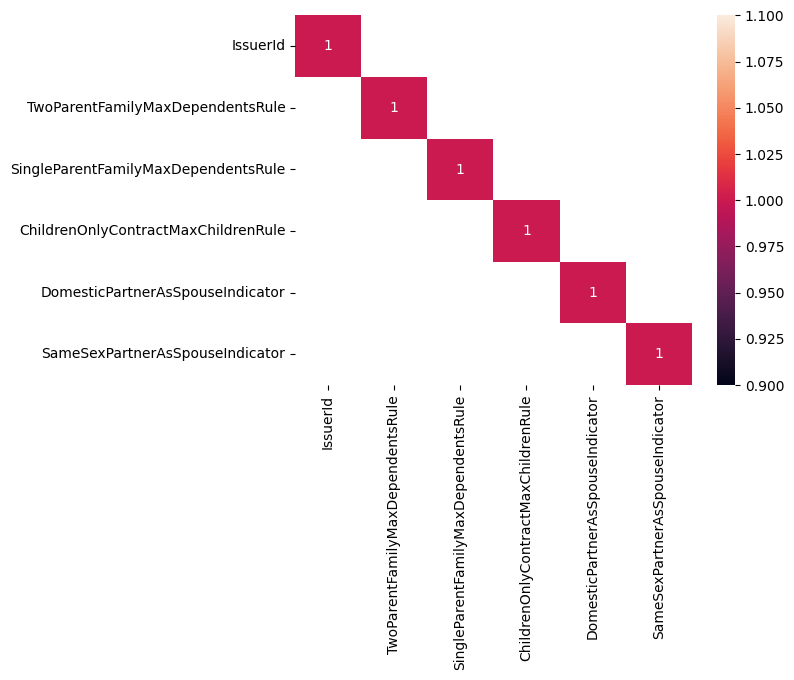

In [76]:
import seaborn as sns
sns.heatmap(corr_mat,annot=True,
            xticklabels=["IssuerId","TwoParentFamilyMaxDependentsRule","SingleParentFamilyMaxDependentsRule",
                      "ChildrenOnlyContractMaxChildrenRule","DomesticPartnerAsSpouseIndicator","SameSexPartnerAsSpouseIndicator" ],
            yticklabels=["IssuerId","TwoParentFamilyMaxDependentsRule","SingleParentFamilyMaxDependentsRule",
                      "ChildrenOnlyContractMaxChildrenRule","DomesticPartnerAsSpouseIndicator","SameSexPartnerAsSpouseIndicator" ])

In [81]:
spark.stop()

## **SQL queries**

In [92]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("PySpark SQL").getOrCreate()

# read the CSV file into a DataFrame
csv_path = "../health_etl/data/BenefitsCostSharing.csv"
benefits = spark.read.csv(csv_path, header=True)

# register the DataFrame as a temporary view
benefits.createOrReplaceTempView("benefits_view")

# define a SQL query
query = "SELECT count(distinct BenefitName)  FROM benefits_view"
# execute the query
results = spark.sql(query)
# show the results
results.show()


+------------------+
|count(BenefitName)|
+------------------+
|                 0|
+------------------+



In [99]:
benefits.show()

+--------------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+----------+--------------------+-------------------+---------+-----+-----------------+-----------------+--------------+----------------+----------------+--------+---------+--------+--------------------+-----------+-----------------+---------------+---------+----------+-------------------+---------+----------+----------+
|         BenefitName|BusinessYear|CoinsInnTier1|CoinsInnTier2|CoinsOutofNet|CopayInnTier1|CopayInnTier2|CopayOutofNet|        EHBVarReason|Exclusions|         Explanation|         ImportDate|IsCovered|IsEHB|IsExclFromInnMOOP|IsExclFromOonMOOP|IsStateMandate|IsSubjToDedTier1|IsSubjToDedTier2|IssuerId|IssuerId2|LimitQty|           LimitUnit|MinimumStay|           PlanId|QuantLimitOnSvc|RowNumber|SourceName|StandardComponentId|StateCode|StateCode2|VersionNum|
+--------------------+------------+-------------+-------------+-------------

In [106]:
query = "SELECT EHBVarReason, count(EHBVarReason) as count, BusinessYear FROM benefits_view GROUP BY EHBVarReason, BusinessYear "
results = spark.sql(query)
results.show()

+--------------------+------+------------+
|        EHBVarReason| count|BusinessYear|
+--------------------+------+------------+
|           Above EHB| 53435|        2014|
|Other Law/Regulation| 35533|        2014|
|           Above Ehb|     1|        2014|
|Dental Only Plan ...| 36813|        2014|
| Substantially Equal|156827|        2014|
|Additional EHB Be...|198651|        2014|
|         Substituted|  1428|        2014|
|           above EHB|     8|        2014|
|Dental Only Plan ...| 62628|        2015|
|         Substituted|  1440|        2015|
|           Above EHB|144359|        2015|
|Additional EHB Be...|320800|        2015|
|Other Law/Regulation| 49913|        2015|
| Substantially Equal|357031|        2015|
|Using Alternate B...|    63|        2015|
|           Above EHB| 68144|        2016|
|         Substituted|  1110|        2016|
|Dental Only Plan ...| 68290|        2016|
|additional EHB Be...|     4|        2016|
|Additional EHB Be...|180013|        2016|
+----------

## Optimization

### Caching

In [97]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("PySpark Cache").getOrCreate()

# read the CSV file into a DataFrame
csv_path = "../health_etl/data/BenefitsCostSharing.csv"
benefits = spark.read.csv(csv_path, header=True)

# register the DataFrame as a temporary view
benefits.createOrReplaceTempView("benefits_view")

# cache the temporary view
spark.catalog.cacheTable("benefits_view")

tmp = benefits.cache()


23/04/30 19:23:59 WARN CacheManager: Asked to cache already cached data.


In [84]:
csv_path = "../health_etl/data/BenefitsCostSharing.csv"

benefits = spark.read.csv(csv_path,header=True)  

In [86]:
benefits.show()

23/04/30 19:15:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+----------+--------------------+-------------------+---------+-----+-----------------+-----------------+--------------+----------------+----------------+--------+---------+--------+--------------------+-----------+-----------------+---------------+---------+----------+-------------------+---------+----------+----------+
|         BenefitName|BusinessYear|CoinsInnTier1|CoinsInnTier2|CoinsOutofNet|CopayInnTier1|CopayInnTier2|CopayOutofNet|        EHBVarReason|Exclusions|         Explanation|         ImportDate|IsCovered|IsEHB|IsExclFromInnMOOP|IsExclFromOonMOOP|IsStateMandate|IsSubjToDedTier1|IsSubjToDedTier2|IssuerId|IssuerId2|LimitQty|           LimitUnit|MinimumStay|           PlanId|QuantLimitOnSvc|RowNumber|SourceName|StandardComponentId|StateCode|StateCode2|VersionNum|
+--------------------+------------+-------------+-------------+-------------

In [89]:
# run a SQL query against the view
query = "SELECT * FROM benefits.BenefitName LIMIT20"
results = spark.sql(query)

# show the query results
results.show()

AnalysisException: Table or view not found: benefits.BenefitName; line 1 pos 14;
'Project [*]
+- 'SubqueryAlias LIMIT20
   +- 'UnresolvedRelation [benefits, BenefitName], [], false


In [108]:
spark.stop()

## JDBC connection

In [ ]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("PySpark JDBC").getOrCreate()

# set the properties for the JDBC connection
jdbc_url = "jdbc:mysql://<hostname>:<port>/<database>"
table_name = "<table_name>"
connection_properties = {
    "user": "<username>",
    "password": "<password>",
    "driver": "com.mysql.jdbc.Driver"
}

# read data from the database using the JDBC connection
df = spark.read.jdbc(url=jdbc_url, table=table_name, properties=connection_properties)

# show the data
df.show()
